Import Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from string import digits

Load Dataset into data_path variable

In [2]:
data_path = "islcorpus2.csv"

Read lines

In [3]:
lines_raw = pd.read_csv(data_path, header = 0)
lines_raw.sample(5)

,Input,Output
138,I happy before,I was happy
43,I live Pune,I live in Pune
104,he buy book yesterday,yesterday he bought a book
58,evening 7,The time is 7 pm
80,I come 2 day back,I came 2 days back


Preprocessing inputs

In [4]:
def preprocess_sentence(sentence):
#sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

Adding start and end tag

In [5]:
isl_sentence = u"I see car"
eng_sentence = u"i see the car"
print(preprocess_sentence(isl_sentence))
print(preprocess_sentence(eng_sentence).encode('utf-8'))

start_ i see car _end
b'start_ i see the car _end'


Create dataset function

In [6]:
def create_dataset(path, num_examples):
    lines = io.open(path,encoding = 'UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split(',')]for l in lines[:num_examples]]
    print(path)
    return zip(*word_pairs)

In [7]:
sample_size= 370
source, target = create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])
type(target)

islcorpus2.csv
start_ do job what _end
start_ what job do you do ? _end


tuple

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
source_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [10]:
target_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding = 'post')
print(len(target_tensor[0]))

11


In [11]:
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

11
9


In [12]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)
print(len(source_train_tensor), len(source_test_tensor), len(target_train_tensor), len(target_test_tensor))

296 74 296 74


In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size=0.1)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

333 333 37 37


In [14]:
type(input_tensor_train)

numpy.ndarray

In [15]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ()

print ("Target Language; index to word mapping")
convert( target_sentence_tokenizer, target_train_tensor[0])
type(source_train_tensor)
type(target_train_tensor)

Input Language; index to word mapping
1 ----> start_
12 ----> my
51 ----> room
52 ----> clean
7 ----> before
2 ----> _end

Target Language; index to word mapping
1 ----> start_
3 ----> i
23 ----> was
115 ----> cleaning
13 ----> my
61 ----> room
2 ----> _end


numpy.ndarray

In [17]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 16
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 9]), TensorShape([16, 11]))

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 9, 1024)
Encoder Hidden state shape: (batch size, units) (16, 1024)


In [21]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        print('\n******* Luong Attention  STARTS******')
        print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
        print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
    
        print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)


        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        print('values_transposed:(batch_size, hidden size, max_len) ', values_transposed.shape)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        #BAHDANAU ADDITIVE:
        #score = self.V(tf.nn.tanh(
        #    self.W1(query_with_time_axis) + self.W2(values)))
    
        #LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

        print('score: (batch_size, max_length, 1) ',score.shape)
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)


        print('\n******* Luong Attention ENDS******')
        return context_vector, attention_weights

In [22]:
attention_layer = LuongAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 9)
score: (batch_size, max_length, 1)  (16, 9, 1)
attention_weights: (batch_size, max_length, 1)  (16, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******
Attention result shape: (batch size, units) (16, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (16, 9, 1)


In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
        self.attention = LuongAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

    # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 9)
score: (batch_size, max_length, 1)  (16, 9, 1)
attention_weights: (batch_size, max_length, 1)  (16, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******
Decoder output shape: (batch_size, vocab size) (16, 308)


In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [26]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [28]:
steps_per_epoch

18

In [29]:
EPOCHS = 40
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 9)
score: (batch_size, max_length, 1)  (16, 9, 1)
attention_weights: (batch_size, max_length, 1)  (16, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 9)
score: (batch_size, max_length, 1)  (16, 9, 1)
att


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 9)
score: (batch_size, max_length, 1)  (16, 9, 1)
attention_weights: (batch_size, max_length, 1)  (16, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 9)
score: (batch_size, max_length, 1)  (16, 9, 1)
att

In [30]:
def evaluate(sentence):
    attention_plot = np.zeros((max_target_length, max_source_length))

    sentence = preprocess_sentence(sentence)
    #print(sentence)
    #print(source_sentence_tokenizer.word_index)

    inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

    for t in range(max_target_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_sentence_tokenizer.index_word[predicted_id] + ' '

        if target_sentence_tokenizer.index_word[predicted_id] == '_end':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [31]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
  
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [33]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


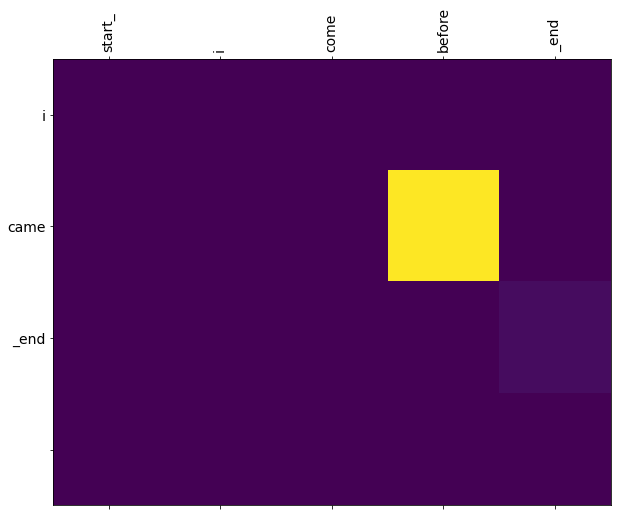

In [34]:
translate(u'i come before')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


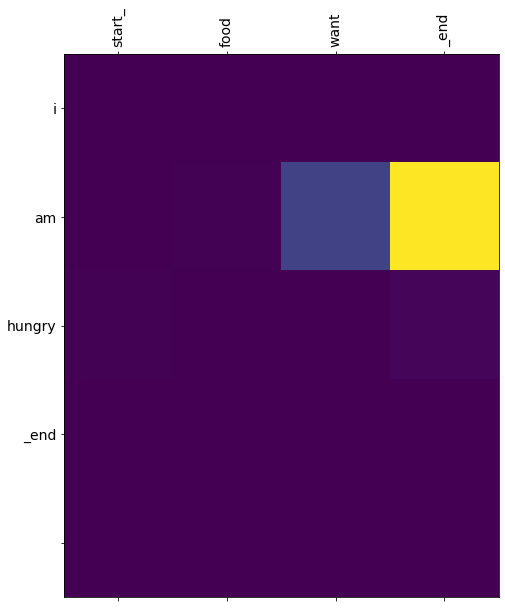

In [35]:
translate(u'food want')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


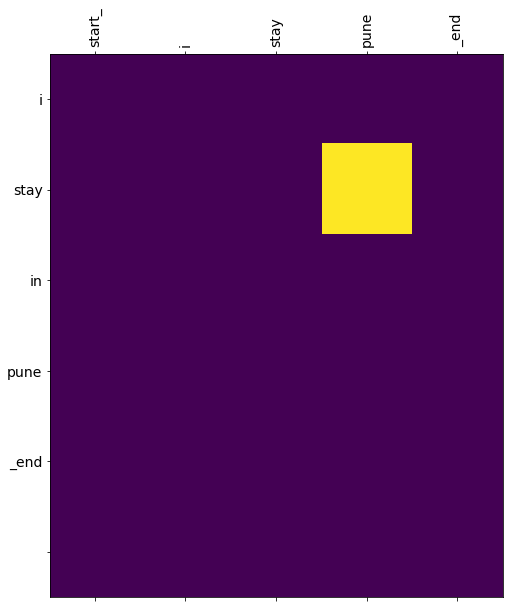

In [36]:
translate(u'i stay pune')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


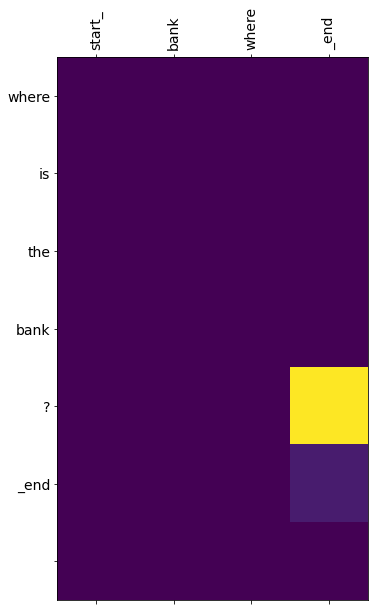

In [37]:
translate(u'bank where')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


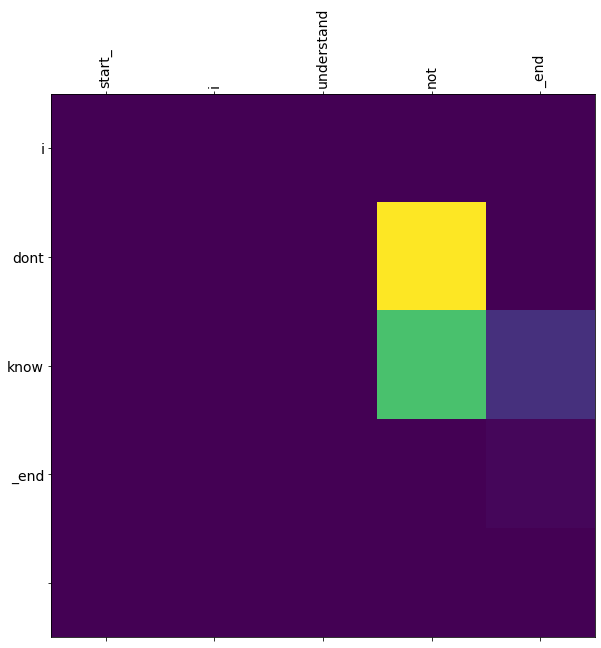

In [38]:
translate(u'i understand not')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


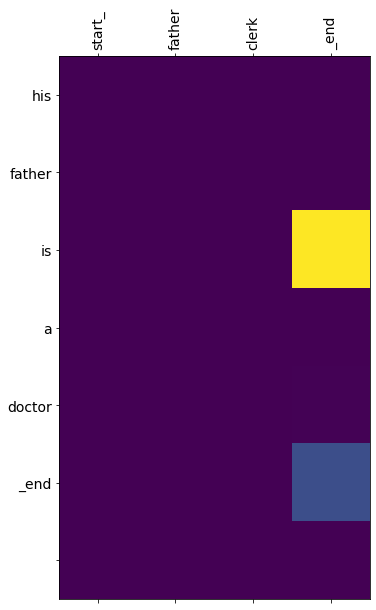

In [39]:
translate(u'father clerk')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


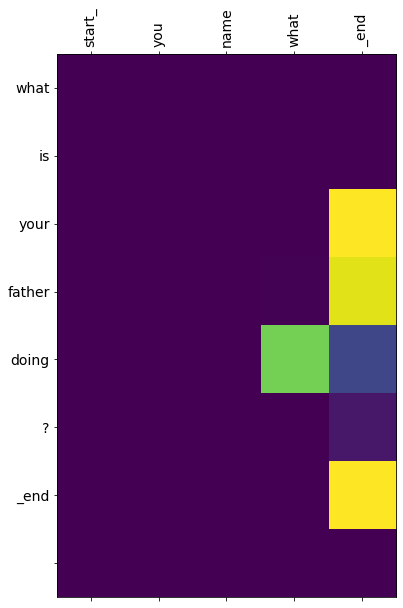

In [40]:
translate(u'you name what')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


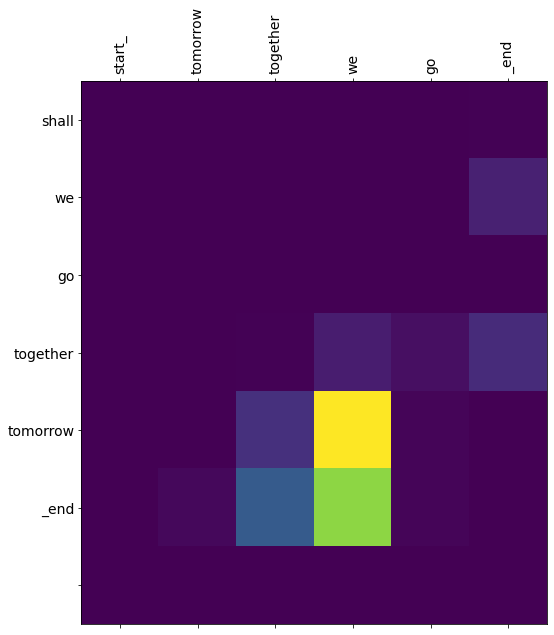

In [41]:
translate(u'tomorrow together we go')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


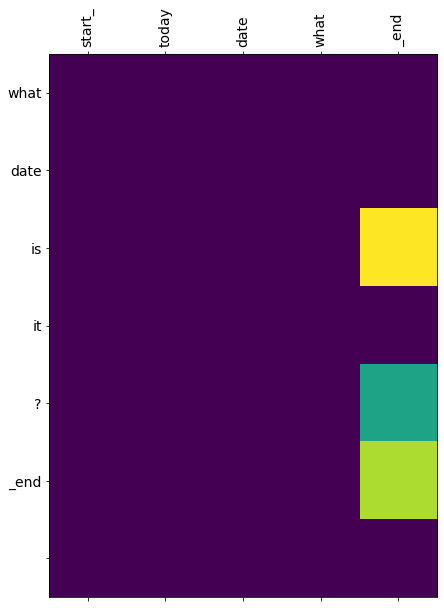

In [42]:
translate(u'today date what')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


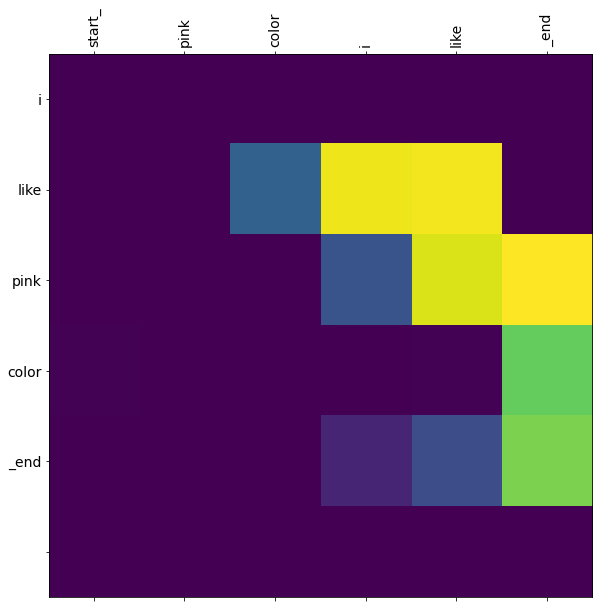

In [43]:
translate(u'pink color i like')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


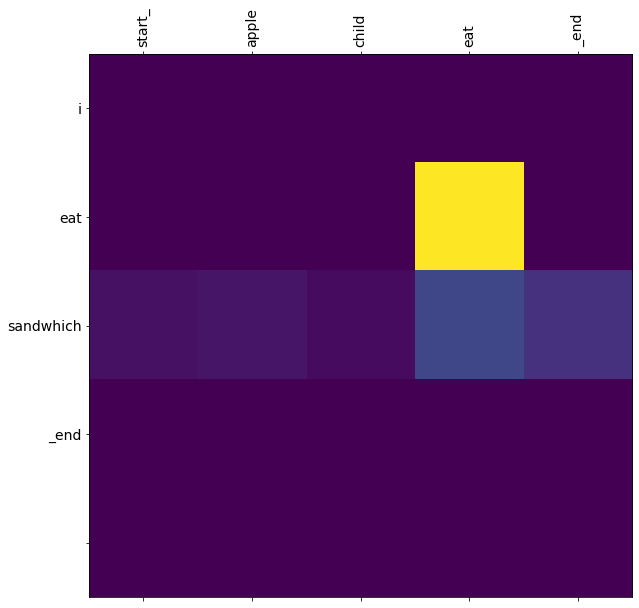

In [44]:
translate(u'apple child eat')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


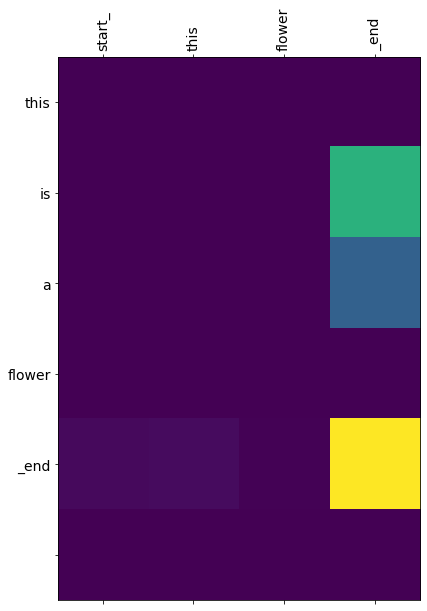

In [45]:
translate(u'this flower')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


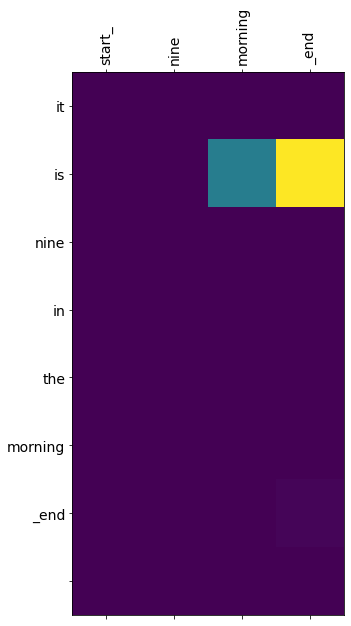

In [46]:
translate(u'nine morning')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


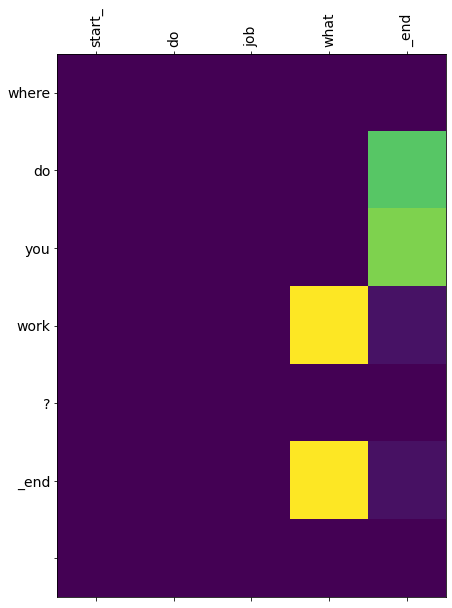

In [47]:
translate(u'do job what')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


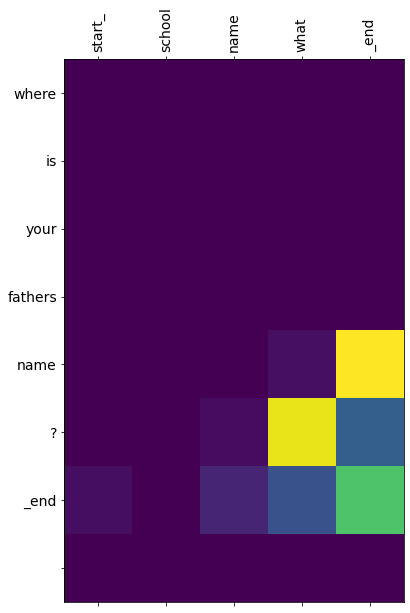

In [48]:
translate(u'school name what')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


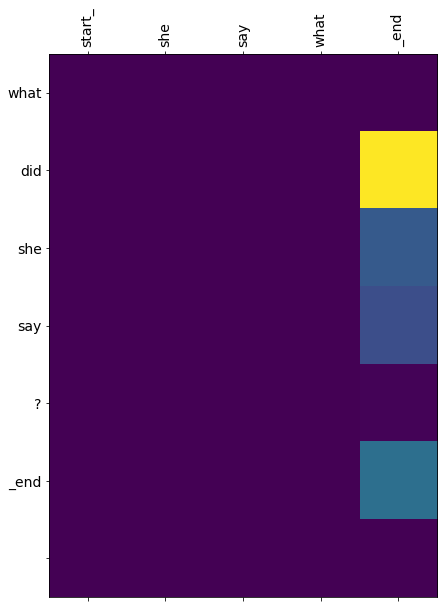

In [49]:
translate(u'she say what')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weights: (batch_size, max_length, 1)  (1, 9, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 9, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 9, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 9)
score: (batch_size, max_length, 1)  (1, 9, 1)
attention_weight

<ipython-input-31-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


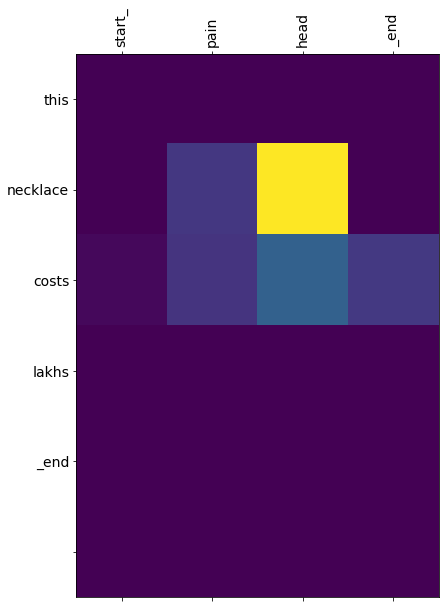

In [50]:
translate(u'pain head')